Plot ACFs

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 

import pickle
import numpy as np
import pandas as pd

from isttc.scripts.cfg_global import project_folder_path
from isttc.tau import func_single_exp_monkey

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'synthetic_dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'

save_fig = False

### Load data (spike trains and calculated acf's)

In [3]:
with open(results_folder + 'tau_pearsonr_trial_50ms_20lags_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'tau_isttc_trial_concat_50ms_20lags_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

with open(results_folder + 'tau_isttc_full_50ms_20lags_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'tau_acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')
print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')

summary_tau_df = pd.read_pickle(results_folder + 'summary_tau_all_long_df_all_units.pkl')
print(f'len summary_tau_df {len(summary_tau_df)}')

len pearsonr_trial_avg_dict 100000
len sttc_trial_concat_dict 100000
len isttc_full_dict 100000
len acf_full_dict 100000
len summary_tau_df 400000


In [4]:
summary_tau_df_subset = summary_tau_df.query('method == "acf_full" or method == "isttc_full"')[['unit_id', 'fit_r_squared',
       'acf_decline', 'method', 'tau_ms', 'fr', 'alpha', 'tau_ms_true',
       'tau_diff_abs', 'tau_diff_rel', 'ci_width', 'lv']].copy()
summary_tau_df_subset

,unit_id,fit_r_squared,acf_decline,method,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_width,lv
0,0,9.983688e-01,True,acf_full,110.894975,7.741821,0.851099,150.923515,40.028540,26.522401,1.973503e-01,1.307775
1,1,9.978989e-01,True,acf_full,128.410512,4.394396,0.858098,147.947233,19.536721,13.205195,2.621199e-01,1.345006
2,2,9.849601e-01,True,acf_full,261.372568,8.587393,0.528805,267.002290,5.629722,2.108492,1.786061e+00,1.068416
3,3,8.897188e-01,True,acf_full,197.510466,6.976707,0.300692,194.403797,3.106670,1.598050,3.400250e+00,1.055631
4,4,9.957372e-01,True,acf_full,185.898174,0.950832,0.691458,239.986489,54.088315,22.538067,5.830144e-01,1.357205
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,99995,8.793473e-01,True,isttc_full,99.306590,2.672839,0.244627,125.243251,25.936660,20.709028,1.616330e+00,1.178739
199996,99996,9.944713e-01,True,isttc_full,82.286403,5.754497,0.596987,94.481295,12.194892,12.907203,2.714929e-01,1.353800
199997,99997,9.291005e-01,True,isttc_full,145.325980,5.604441,0.258915,174.189672,28.863692,16.570266,1.815717e+00,1.064661
199998,99998,8.464486e-01,True,isttc_full,78.563818,1.219057,0.187620,76.565797,1.998022,2.609549,1.486167e+00,1.306500


In [5]:
summary_tau_df_subset.keys()

Index(['unit_id', 'fit_r_squared', 'acf_decline', 'method', 'tau_ms', 'fr',
       'alpha', 'tau_ms_true', 'tau_diff_abs', 'tau_diff_rel', 'ci_width',
       'lv'],
      dtype='object')

In [6]:
# get units for which isttc performed better (with fr <= 2.5 and alpha >= 0.7 and at least 20% less REE)
df = summary_tau_df_subset.copy()

# mask_basic = (df['fr'] <= 2.5) & (df['alpha'] >= 0.7)
mask_basic = (df['fr'] >= 8) & (df['alpha'] <= 0.2)
df_basic = df[mask_basic]

# compute tau_diff_rel difference per unit
pivot = df_basic.pivot(index='unit_id', columns='method', values='tau_diff_rel')
# isttc_full is at least 20 lower than acf_full
# cond_diff20 = pivot['isttc_full'] <= (pivot['acf_full'] - 20)
cond_diff20 = pivot['acf_full'] <= (pivot['isttc_full'] - 20)
# isttc_full <= 10
#cond_isttc10 = pivot['isttc_full'] <= 10
cond_isttc10 = pivot['acf_full'] <= 10
# Units satisfying both conditions
selected_units = pivot[cond_diff20 & cond_isttc10].index

df_final = (
    df_basic[df_basic['unit_id'].isin(selected_units)]
    .sort_values(by='unit_id')
    .reset_index(drop=True)
)

df_final

,unit_id,fit_r_squared,acf_decline,method,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_width,lv
0,31,0.871593,True,acf_full,155.993163,9.675422,0.197857,150.122967,5.870196,3.910259,2.743734,1.023090
1,31,0.750596,True,isttc_full,214.552774,9.675422,0.197857,150.122967,64.429807,42.918021,6.238466,1.023090
2,773,0.777544,False,isttc_full,337.385306,8.495859,0.183966,220.406353,116.978952,53.074220,11.638241,0.993732
3,773,0.713648,False,acf_full,233.507615,8.495859,0.183966,220.406353,13.101262,5.944140,7.737581,0.993732
4,1713,0.372975,False,acf_full,246.872695,8.836463,0.176994,247.460110,0.587415,0.237378,17.192914,1.040098
...,...,...,...,...,...,...,...,...,...,...,...,...
191,94817,0.680535,True,isttc_full,139.787306,8.110165,0.176334,106.252769,33.534538,31.561096,4.305749,1.065429
192,95040,0.575721,True,isttc_full,178.930404,9.062495,0.114880,254.430634,75.500230,29.674190,7.279193,1.007844
193,95040,0.586279,False,acf_full,232.871936,9.062495,0.114880,254.430634,21.558698,8.473311,10.220574,1.007844
194,96375,0.427336,False,acf_full,241.527118,8.555635,0.129573,257.602830,16.075712,6.240503,14.858973,1.006538


### Plot

In [7]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2' 
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

#colors = [color_acf_full, color_isttc_full]

In [8]:
def plot_acfs(unit_to_plot, fig_folder):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

    n_lags = 20
    t = np.linspace(0, n_lags, n_lags+1).astype(int)

    axes[0].plot(t[1:], isttc_full_dict[unit_to_plot]['acf'][1:], lw=0, color=color_isttc_full, alpha=1, marker='o', markersize='5')
    axes[0].plot(t[1:], func_single_exp_monkey(t[1:], *isttc_full_dict[unit_to_plot]['taus']['popt']), color=color_isttc_full)
    
    axes[1].plot(t[1:], acf_full_dict[unit_to_plot]['acf'][1:], lw=0, color=color_acf_full, alpha=1, marker='o', markersize='5')
    axes[1].plot(t[1:], func_single_exp_monkey(t[1:], *acf_full_dict[unit_to_plot]['taus']['popt']), color=color_acf_full)
    
    # get analytical tau
    alpha = summary_tau_df[summary_tau_df['unit_id'] == unit_to_plot]['alpha'].values[0] 
    tau_ms = summary_tau_df[summary_tau_df['unit_id'] == unit_to_plot]['tau_ms_true'].values[0]   
    fr = summary_tau_df[summary_tau_df['unit_id'] == unit_to_plot]['fr'].values[0]   

    lags = np.linspace(0, 1000, 21)
    acf_shape = np.exp(-lags / tau_ms)
    
    # iSTTC scaling
    isttc_emp = isttc_full_dict[unit_to_plot]['acf']
    isttc_scale = isttc_emp[1] / acf_shape[1]
    isttc_acf_analytical_scaled = isttc_scale * acf_shape
    
    # ACF scaling
    acf_emp = acf_full_dict[unit_to_plot]['acf']
    acf_scale = acf_emp[1] / acf_shape[1]
    acf_acf_analytical_scaled = acf_scale * acf_shape
    
    axes[0].plot(t[1:], isttc_acf_analytical_scaled[1:], lw=1, color='k', alpha=1)
    axes[1].plot(t[1:], acf_acf_analytical_scaled[1:], lw=1, color='k', alpha=1)
    
    # axes[0].plot(t[1:], acf_analytical[1:], lw=1, color='k', alpha=1)
    # axes[1].plot(t[1:], acf_analytical[1:], lw=1, color='k', alpha=1)
    
    fig.suptitle(f'Unit {unit_to_plot}: alpha {alpha:.2f}, fr {fr:.2f} Hz, tau {tau_ms:.2f} ms', y=1.1)
    
    isttc_ree = summary_tau_df.query('unit_id == @unit_to_plot and method == "isttc_full"')['tau_diff_rel'].values[0]
    isttc_r2 = summary_tau_df.query('unit_id == @unit_to_plot and method == "isttc_full"')['fit_r_squared'].values[0]
    isttc_tau = summary_tau_df.query('unit_id == @unit_to_plot and method == "isttc_full"')['tau_ms'].values[0]
    axes[0].set_title(f'iSTTC: REE {isttc_ree:.2f}%, R-squared {isttc_r2:.2f},\n tau {isttc_tau:.2f}')
    
    acf_ree = summary_tau_df.query('unit_id == @unit_to_plot and method == "acf_full"')['tau_diff_rel'].values[0]
    acf_r2 = summary_tau_df.query('unit_id == @unit_to_plot and method == "acf_full"')['fit_r_squared'].values[0]
    acf_tau = summary_tau_df.query('unit_id == @unit_to_plot and method == "acf_full"')['tau_ms'].values[0]
    axes[1].set_title(f'ACF: REE {acf_ree:.2f}%, R-squared {acf_r2:.2f},\n tau {acf_tau:.2f}')
    
    for ax in axes.flat:
        ax.set_ylabel('ACF (a.u.)')
        ax.set_xlabel('Time (ms)')
        ax.set_xticks(np.linspace(0, 20, 11).astype(int))
        ax.set_xticklabels(np.linspace(0, 1000, 11).astype(int))
        ax.set_xlim([0,20])
    
    sns.despine()

    fig.savefig(fig_folder + f"acf_plot_unit_{unit_to_plot}.png", dpi=300, bbox_inches='tight')
    plt.close(fig) 

#### ACFs where iSTTC is better

In [9]:
units_to_plot = df_final.query('method == "isttc_full"')['unit_id'].values
print(f'len units_to_plot {len(units_to_plot)}')

len units_to_plot 98


In [10]:
for unit_id in units_to_plot:
    plot_acfs(unit_id, results_folder + 'acf_plots\\full_acf_better\\')

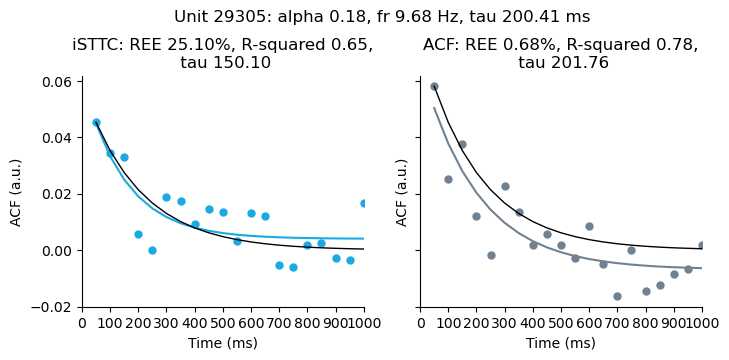

In [14]:
unit_to_plot = 29305

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

n_lags = 20
t = np.linspace(0, n_lags, n_lags+1).astype(int)

axes[0].plot(t[1:], isttc_full_dict[unit_to_plot]['acf'][1:], lw=0, color=color_isttc_full, alpha=1, marker='o', markersize='5')
axes[0].plot(t[1:], func_single_exp_monkey(t[1:], *isttc_full_dict[unit_to_plot]['taus']['popt']), color=color_isttc_full)

axes[1].plot(t[1:], acf_full_dict[unit_to_plot]['acf'][1:], lw=0, color=color_acf_full, alpha=1, marker='o', markersize='5')
axes[1].plot(t[1:], func_single_exp_monkey(t[1:], *acf_full_dict[unit_to_plot]['taus']['popt']), color=color_acf_full)

# get analytical tau
alpha = summary_tau_df[summary_tau_df['unit_id'] == unit_to_plot]['alpha'].values[0] 
tau_ms = summary_tau_df[summary_tau_df['unit_id'] == unit_to_plot]['tau_ms_true'].values[0]   
fr = summary_tau_df[summary_tau_df['unit_id'] == unit_to_plot]['fr'].values[0]   

lags = np.linspace(0, 1000, 21)
acf_shape = np.exp(-lags / tau_ms)

# iSTTC scaling
isttc_emp = isttc_full_dict[unit_to_plot]['acf']
isttc_scale = isttc_emp[1] / acf_shape[1]
isttc_acf_analytical_scaled = isttc_scale * acf_shape

# ACF scaling
acf_emp = acf_full_dict[unit_to_plot]['acf']
acf_scale = acf_emp[1] / acf_shape[1]
acf_acf_analytical_scaled = acf_scale * acf_shape

# lags = np.linspace(0, 1000, 21) 
# acf_analytical = np.exp(-np.abs(lags) / tau_ms)

# isttc_scale = isttc_full_dict[unit_to_plot]['acf'][1] 
# isttc_acf_analytical_scaled = isttc_scale * np.exp(-lags / tau_ms)

# acf_scale = acf_full_dict[unit_to_plot]['acf'][1] 
# acf_acf_analytical_scaled = acf_scale * np.exp(-lags / tau_ms)

axes[0].plot(t[1:], isttc_acf_analytical_scaled[1:], lw=1, color='k', alpha=1)
axes[1].plot(t[1:], acf_acf_analytical_scaled[1:], lw=1, color='k', alpha=1)

fig.suptitle(f'Unit {unit_to_plot}: alpha {alpha:.2f}, fr {fr:.2f} Hz, tau {tau_ms:.2f} ms', y=1.1)

isttc_ree = summary_tau_df.query('unit_id == @unit_to_plot and method == "isttc_full"')['tau_diff_rel'].values[0]
isttc_r2 = summary_tau_df.query('unit_id == @unit_to_plot and method == "isttc_full"')['fit_r_squared'].values[0]
isttc_tau = summary_tau_df.query('unit_id == @unit_to_plot and method == "isttc_full"')['tau_ms'].values[0]
axes[0].set_title(f'iSTTC: REE {isttc_ree:.2f}%, R-squared {isttc_r2:.2f},\n tau {isttc_tau:.2f}')

acf_ree = summary_tau_df.query('unit_id == @unit_to_plot and method == "acf_full"')['tau_diff_rel'].values[0]
acf_r2 = summary_tau_df.query('unit_id == @unit_to_plot and method == "acf_full"')['fit_r_squared'].values[0]
acf_tau = summary_tau_df.query('unit_id == @unit_to_plot and method == "acf_full"')['tau_ms'].values[0]
axes[1].set_title(f'ACF: REE {acf_ree:.2f}%, R-squared {acf_r2:.2f},\n tau {acf_tau:.2f}')

for ax in axes.flat:
    ax.set_ylabel('ACF (a.u.)')
    ax.set_xlabel('Time (ms)')
    ax.set_xticks(np.linspace(0, 20, 11).astype(int))
    ax.set_xticklabels(np.linspace(0, 1000, 11).astype(int))
    ax.set_xlim([0,20])

sns.despine()

fig.savefig(results_folder + 'acf_plots\\full_for_rev_acf_better\\' + f"acf_plot_unit_{unit_to_plot}.png", dpi=300, bbox_inches='tight')
fig.savefig(results_folder + 'acf_plots\\full_for_rev_acf_better\\' + f"acf_plot_unit_{unit_to_plot}.svg", dpi=300, bbox_inches='tight')